In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cvxpy as cp
#import gurobipy

In [167]:
df = pd.read_csv("/Users/ridhitbhura/Desktop/Cornell/Fall 2021/ORIE 4741/orie4741-finalproject/surv.csv")
df
Y_correct = df['Categories']

In [168]:
df = df.replace('+',1)

In [169]:
df = df.replace('-',0)
df = df.replace('PUS',1)
df = df.replace('PIM',2)
df = df.replace('PWS',3)

In [170]:
df

,A01,A02,A03,A04,A05,A06,A07,Categories
0,1,1,1,1,1,0,0,1
1,1,1,0,1,1,0,0,1
2,1,1,1,1,0,1,0,1
3,1,1,0,1,0,1,0,1
4,1,0,0,0,0,0,1,1
5,1,1,1,0,0,0,1,1
6,1,1,0,0,0,0,1,1
7,1,1,1,1,0,0,0,1
8,1,0,0,1,1,0,0,2
9,0,1,0,1,1,0,0,2


In [171]:
Y_correct

0     PUS
1     PUS
2     PUS
3     PUS
4     PUS
5     PUS
6     PUS
7     PUS
8     PIM
9     PIM
10    PIM
11    PIM
12    PIM
13    PWS
Name: Categories, dtype: object

In [172]:
def sim(i, j):
    s = 0
    if df.iloc[i, 1] == df.iloc[j, 1]:
        s += 10
    if df.iloc[i, 5] == df.iloc[j, 5]:
        s += 20
    for k in range(2):
        if df.iloc[i, k+3] == df.iloc[j, k+3]:
            s += 4
    s += 10 * (df.iloc[i, 4] * df.iloc[j, 4])
    s += df.iloc[i, 6] + df.iloc[j, 6]
    return s

In [173]:
def dist(i, j):
    dist = []
    dist=[1,3,4,5,6,6]
    for ind in (range(1,7)):
        dist.append((df.iloc[i, ind] - df.iloc[j, ind])**2)
    return np.sqrt(sum(dist))

In [174]:
similarity = np.zeros((14, 14))
dists = np.zeros((14, 14))

In [175]:
for i in range(14):
    for j in range(14):
        if i != j:
            similarity[i, j] = sim(i, j)
            dists[i, j] = dist(i, j)
        else:
            dists[i, j] = 10

In [176]:
print(dists)

[[10.          5.09901951  5.19615242  5.29150262  5.47722558  5.29150262
   5.38516481  5.09901951  5.19615242  5.09901951  5.38516481  5.29150262
   5.38516481  5.47722558]
 [ 5.09901951 10.          5.29150262  5.19615242  5.38516481  5.38516481
   5.29150262  5.19615242  5.09901951  5.          5.29150262  5.19615242
   5.29150262  5.38516481]
 [ 5.19615242  5.29150262 10.          5.09901951  5.47722558  5.29150262
   5.38516481  5.09901951  5.38516481  5.29150262  5.19615242  5.09901951
   5.38516481  5.47722558]
 [ 5.29150262  5.19615242  5.09901951 10.          5.38516481  5.38516481
   5.29150262  5.19615242  5.29150262  5.19615242  5.09901951  5.
   5.29150262  5.38516481]
 [ 5.47722558  5.38516481  5.47722558  5.38516481 10.          5.19615242
   5.09901951  5.38516481  5.29150262  5.38516481  5.29150262  5.38516481
   5.09901951  5.        ]
 [ 5.29150262  5.38516481  5.29150262  5.38516481  5.19615242 10.
   5.09901951  5.19615242  5.47722558  5.38516481  5.47722558  5.38

In [177]:
def KNNgraph(n, s):
    weights = np.zeros((14, 14))
    for a in range(14):
        arr = s[a,:]
        tmp = np.argpartition(arr, -n)[-n:]
        ind = tmp[np.argsort((-arr)[tmp])]
        for b in ind:
            weights[a, b] = s[a, b]
            weights[b, a] = s[a, b]
    return weights

In [178]:
def neighborhoodGraph(eps, s):
    weights = np.zeros((14, 14))
    for a in range(14):
        for b in range(14):
            if dists[a, b] < eps:
                weights[a, b] = s[a, b]
                weights[b, a] = s[a, b]
    return weights

In [179]:
def bMatchingGraph(b):
    print(cp.installed_solvers())
    x = cp.Variable((14, 14), boolean=True, name='x')
    objective = sum(dists[a, b] * x[a, b] for a in range(14) for b in range(14))
    constraints = []
    constraints += [x == x.T]
    for s in range(194):
        constraints += [np.sum(x[s, :]) == b]
        constraints += [x[s, s] == 0]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver='ECOS_BB',verbose=False)
    print(x)
    print(x.value)
    return x

In [180]:
w = KNNgraph(4, similarity)

In [181]:
class GraphVisualization:
    def __init__(self):
        # visual is a list which stores all
        # the set of edges that constitutes a
        # graph
        self.visual = []

    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)

    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()

In [182]:
G = GraphVisualization()

In [183]:
for i in range(14):
    for j in range(14):
        if w[i, j] != 0:
            G.addEdge(i, j)

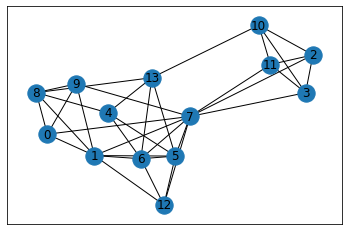

In [184]:
G.visualize()

In [185]:
degree = np.zeros((14, 14))
for i in range(14):
    degree[i][i] = sum(w[i,:])


In [186]:
laplacian = degree - w

In [187]:
from numpy.linalg import matrix_power, inv

In [188]:
t = np.sqrt((np.linalg.inv(degree)))
norm_laplacian = t @ laplacian @ t


In [189]:
Y_embed = np.zeros(14)
s = 0
for i in range(14):
    s += np.norm(Y_combined[i] - (w[i,:].dot(Y_combined)))**2

AttributeError: module 'numpy' has no attribute 'norm'

In [190]:
Y_embed
Y_correct = Y_correct.replace('PUS',1)
Y_correct = Y_correct.replace('PIM',2)
Y_correct = Y_correct.replace('PWS',3)
Y_correct

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     2
9     2
10    2
11    2
12    2
13    3
Name: Categories, dtype: int64

In [191]:
import random
indices = []
for i in range(14):
    indices.append(i)

labeled_indices = random.sample(indices, 10)
unlabeled_indices = []

for j in indices:
    if labeled_indices.count(j) == 0:
        unlabeled_indices.append(j)

In [192]:
Y = np.zeros(10)
X = np.zeros((14, 8))
Y_true = np.zeros(4)
Y_buff = np.zeros(4)
arr = np.asarray(df)
arr


array([[1, 1, 1, 1, 1, 0, 0, 1],
       [1, 1, 0, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 0, 0, 2],
       [0, 1, 0, 1, 1, 0, 0, 2],
       [1, 0, 0, 1, 0, 1, 0, 2],
       [0, 1, 0, 1, 0, 1, 0, 2],
       [0, 1, 0, 0, 0, 0, 1, 2],
       [0, 0, 0, 0, 0, 0, 1, 3]])

In [193]:

for i in range(10):
    Y[i] = Y_correct[labeled_indices[i]]
    X[i] = arr[labeled_indices[i]]
    
for j in range(4):
    X[10 + j] = arr[unlabeled_indices[j]]
    Y_true[j] = Y_correct[unlabeled_indices[j]]



In [194]:
Y_combined = np.concatenate((Y, Y_buff), axis = 0)
Y_combined

array([2., 1., 1., 2., 1., 1., 1., 2., 2., 3., 0., 0., 0., 0.])

In [195]:
Y1 = np.zeros(10)
duu = degree[10:, 10:]
wuu = w[10:, 10:]
wul = w[10:, :10]
k = np.linalg.inv(duu - wuu) @ wul
pred = k @ Y1


In [196]:
Y_true

array([1., 1., 1., 2.])

In [197]:
for i in range(10):
    w = KNNgraph(i, similarity)
   
    degree = np.zeros((14, 14))
    for i in range(14):
        degree[i][i] = sum(w[i,:])
    duu = degree[10:, 10:]
    wuu = w[10:, 10:]
    wul = w[10:, :10]
    k = np.linalg.inv(duu - wuu) @ wul
    pred = k @ Y     
    print(np.sum(np.abs(Y_true - pred))/4)

0.5359450942898052
0.5760869565217391
0.37526536027760765
0.49935428325441245
0.507873009457436
0.5321897706822024
0.5302712649884228
0.539266518398345
0.5117085675576378
0.4949316673456508


In [198]:
degree

array([[345.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0., 345.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0., 195.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   0., 195.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 264.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 339.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 339.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 343.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 277.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 303.,   0.,
          0.,   0

In [200]:
def LGC(w, deg):
    y_pred = cp.Variable(14)
    objective = 0
    constraints = []
    for i in range(14):
        constraints += [y_pred[i] >=0]
        constraints += [y_pred[i] <=7]
    
        for j in range(14):
            t = w[i, j]*((1/np.sqrt(deg[i,i])*y_pred[i]) - (1/np.sqrt(deg[j, j])*y_pred[j]))**2
            objective += t
    objective += sum((y_pred[:10] - Y)**2)
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP)
    return y_pred.value


In [203]:
x = LGC(w, degree)
# print(y_pred.value)

In [206]:
x

array([1.82324197, 1.51820218, 1.20569662, 1.50070419, 1.33703245,
       1.47836972, 1.47836972, 1.8052302 , 1.69330389, 2.04508549,
       1.12783485, 1.29177139, 1.67943572, 1.48337548])

In [208]:
p = x
print(np.sum(np.abs(Y_true - p[10:]))/4)

0.4039166202186645


In [209]:
for i in range(10):
    w = KNNgraph(i, similarity)
    deg = np.zeros((14, 14))
    for i in range(14):
        deg[i][i] = sum(w[i,:])
    val = LGC(w, deg)
    print(np.sum(np.abs(Y_true - val[10:]))/4)


0.4278616868129574
1.0129983516244698
0.4525297062653373
0.4637896019379282
0.3953250203381764
0.4928752763115165
0.4710896950218696
0.45985203659094753
0.42301308290829315
0.4039166202186645


In [220]:
df
df['row_num'] = np.arange(len(df))
df

,A01,A02,A03,A04,A05,A06,A07,Categories,row_num
0,1,1,1,1,1,0,0,1,0
1,1,1,0,1,1,0,0,1,1
2,1,1,1,1,0,1,0,1,2
3,1,1,0,1,0,1,0,1,3
4,1,0,0,0,0,0,1,1,4
5,1,1,1,0,0,0,1,1,5
6,1,1,0,0,0,0,1,1,6
7,1,1,1,1,0,0,0,1,7
8,1,0,0,1,1,0,0,2,8
9,0,1,0,1,1,0,0,2,9


In [239]:
from karateclub import DeepWalk
import networkx as nx
G1 = nx.from_pandas_edgelist(df, "row_num", "Categories", create_using=nx.Graph())
model = DeepWalk(walk_length=10, dimensions=7, window_size=5)
model.fit(G1)
embedding = model.get_embedding()

In [240]:
print(embedding.shape)
nodes = list(range(10))

(14, 7)


In [241]:
from sklearn.decomposition import PCA
def plot_nodes(node_no):
    X = embedding[node_no]
      
    pca = PCA(n_components=2)
    pca_out= pca.fit_transform(X)
      
      
    plt.figure(figsize=(15,10))
    plt.scatter(pca_out[:, 0], pca_out[:, 1])
    for i, node in enumerate(node_no):
        plt.annotate(node, (pca_out[i, 0], pca_out[i, 1]))
    plt.xlabel('Label_1')
    plt.ylabel('label_2')
    plt.show()


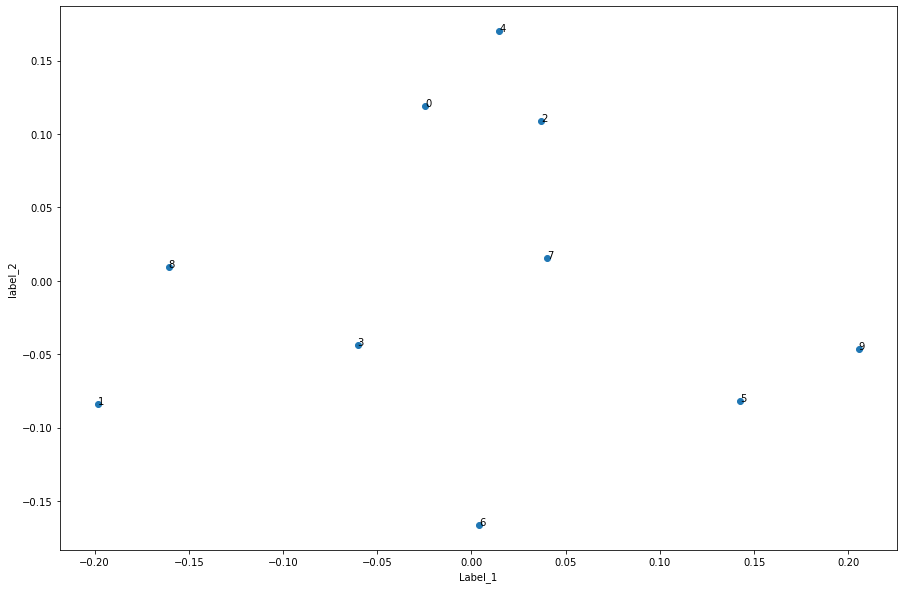

In [242]:
plot_nodes(nodes)